# BigDL object detection demo

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Disable auto scroll

In [2]:
from bigdl.util.common import *
from bigdl.transform.vision.image import *
from bigdl.zoo.models import *
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image, display
%matplotlib inline

JavaCreator.set_creator_class("com.intel.analytics.zoo.models.pythonapi.PythonModels")
init_engine()

Verify and read some environment information (e.g. executor number and executor core number)

## Download and load pretrained BigDL model

SSD with mobilenet: https://s3-ap-southeast-1.amazonaws.com/bigdl-models/object-detection/bigdl_ssd-mobilenet-300x300_PASCAL_0.4.0.model

In [3]:
from bigdl.nn.layer import Model

# load model
model = Model.loadModel("bigdl_ssd-mobilenet-300x300_PASCAL_0.4.0.model")
print 'load model done'

load model done


## Construct Predictor

In [4]:
predictor = Predictor(model)

creating: createPredictor


## Run image detection and visualization on Spark
Having prepared the predictor, we can start detecting objects.
* Read the image as `ImageFrame` (local/distributed)
* Perform prediction
* Visualize the detections in original images

### Predict DistributedImageFrame

creating: createVisualizer


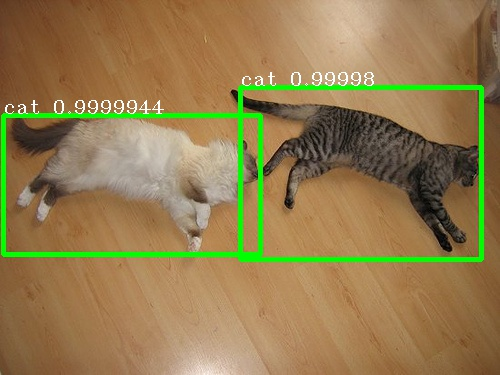

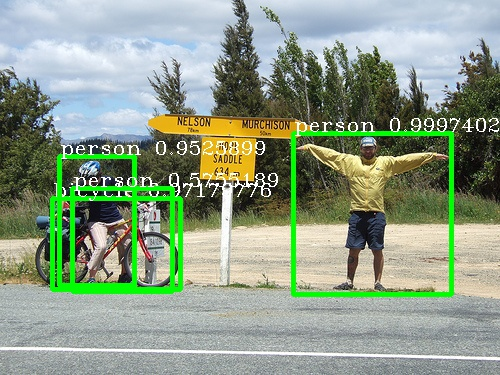

In [5]:
folder = "image"
image_frame = ImageFrame.read(folder, sc, 2)

output = predictor.predict(image_frame)

visualizer = Visualizer(predictor.configure.label_map())
visualized = visualizer(output).get_image(to_chw=False).collect()

# visualize detections
for img_id in range(len(visualized)):
    cv2.imwrite('/tmp/tmp' + str(img_id) + '.jpg', visualized[img_id])
    display(Image(filename='/tmp/tmp' + str(img_id) + '.jpg'))
    

### Predict LocalImageFrame

creating: createVisualizer
/tmp/tmp0.jpg


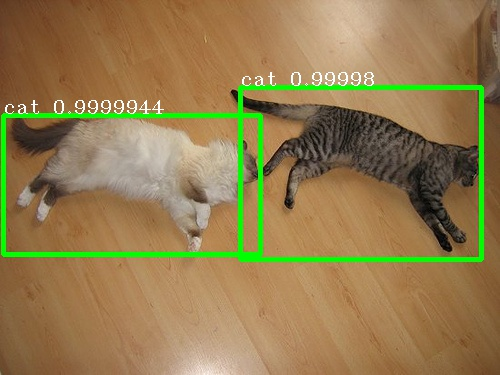

/tmp/tmp1.jpg


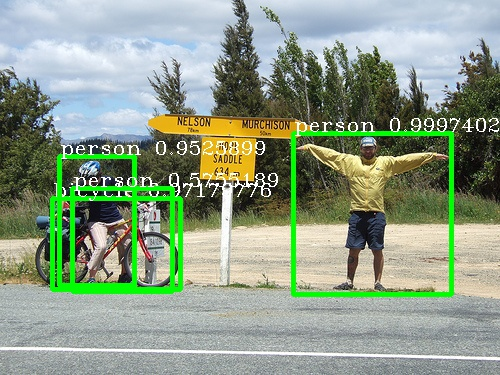

In [6]:
folder = "image"
image_frame = ImageFrame.read(folder)

output = predictor.predict(image_frame)

visualizer = Visualizer(predictor.configure.label_map())
visualized = visualizer(output).get_image(to_chw=False)

# visualize detections
for img_id in range(len(visualized)):
    out_name = '/tmp/tmp' + str(img_id) + '.jpg'
    print out_name
    cv2.imwrite(out_name, visualized[img_id])
    display(Image(filename=out_name))

## Video detection

Next we will play with some videos. To achieve this, I adopt moviepy for video read/write.

The detection steps are similar to the above image detection.
* Read video with VideoFileClip, and for demo simplicity, I extract the first 10 seconds of videos with 5 fps. Then convert the frames to spark RDD and preprocess the RDD.
* Apply BigDL model to do the object detection.
* Save the detected frames back to video with ImageSequenceClip.

In [7]:
from moviepy.editor import *
myclip = VideoFileClip("/home/jxy/Downloads/Dog imitates baby.mp4").subclip(139,149)

video_rdd = sc.parallelize(myclip.iter_frames(fps=5))
image_frame = DistributedImageFrame(video_rdd)

predictor = Predictor(model)

output = predictor.predict(image_frame)

visualizer = Visualizer(predictor.configure.label_map())
results = visualizer(output).get_image(to_chw=False).collect()

results = filter(lambda x: x!=None, results)
clip = ImageSequenceClip(results, fps=5)

output_path = '/tmp/out.mp4'
%time clip.write_videofile(output_path, audio=False)

creating: createDistributedImageFrame
creating: createPredictor
creating: createVisualizer
[MoviePy] >>>> Building video /tmp/out.mp4
[MoviePy] Writing video /tmp/out.mp4


100%|██████████| 50/50 [00:00<00:00, 108.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /tmp/out.mp4 

CPU times: user 140 ms, sys: 56 ms, total: 196 ms
Wall time: 1.41 s


In [8]:
import io
import base64
from IPython.display import HTML

clip = ImageSequenceClip(results, fps=5)

output_path = '/tmp/out.mp4'
%time clip.write_videofile(output_path, audio=False)


video = io.open(output_path, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test"  width="600"controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))


[MoviePy] >>>> Building video /tmp/out.mp4
[MoviePy] Writing video /tmp/out.mp4


100%|██████████| 50/50 [00:00<00:00, 113.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /tmp/out.mp4 

CPU times: user 152 ms, sys: 48 ms, total: 200 ms
Wall time: 1.47 s


In [12]:
from moviepy.editor import *
clip = VideoFileClip("/tmp/out.mp4")
clip.write_gif("final.gif")


[MoviePy] Building file final.gif with imageio


 98%|█████████▊| 50/51 [00:09<00:00,  4.72it/s]


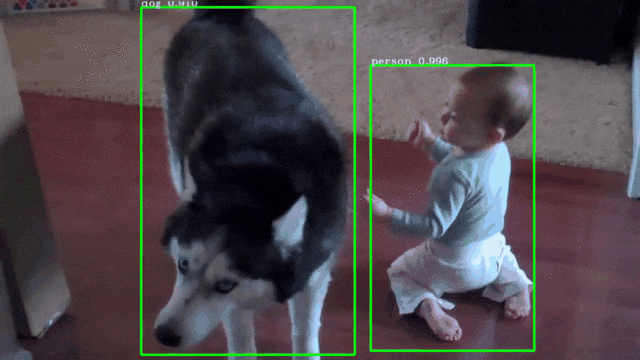

In [16]:
from IPython.display import Image
from IPython.display import display
with open("final.gif",'rb') as f:
    display(Image(f.read()), format='png')